<a href="https://colab.research.google.com/github/theclassofai/COVID_19/blob/master/Covid_19_Analysis_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Load Basic Packages for Data Analysis

In [1]:
 # Load Basic Libraries
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, save
import plotly.graph_objects as go
import sklearn
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.plotting.register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2. Load Data from Kaggle (covid19-global-forecasting-week-3)

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "sagihaider" # username from the json file
os.environ['KAGGLE_KEY'] = "08f30f17342835b8df3640d23ceac8f7" # key from the json file
!kaggle competitions download -c covid19-global-forecasting-week-4

  0% 0.00/388k [00:00<?, ?B/s]
100% 388k/388k [00:00<00:00, 57.1MB/s]
  0% 0.00/121k [00:00<?, ?B/s]
100% 121k/121k [00:00<00:00, 40.0MB/s]
  0% 0.00/963k [00:00<?, ?B/s]
100% 963k/963k [00:00<00:00, 63.4MB/s]


In [3]:
train_df=pd.read_csv('/content/train.csv')
test_df=pd.read_csv('/content/test.csv')
all_data=pd.concat([train_df,test_df],axis=0) # combined train and test data
all_data.reset_index(drop=True) # reset index with drop true

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId
0,1.0,NaN,Afghanistan,2020-01-22,0.0,0.0,NaN
1,2.0,NaN,Afghanistan,2020-01-23,0.0,0.0,NaN
2,3.0,NaN,Afghanistan,2020-01-24,0.0,0.0,NaN
3,4.0,NaN,Afghanistan,2020-01-25,0.0,0.0,NaN
4,5.0,NaN,Afghanistan,2020-01-26,0.0,0.0,NaN
...,...,...,...,...,...,...,...
38807,NaN,NaN,Zimbabwe,2020-05-10,NaN,NaN,13455.0
38808,NaN,NaN,Zimbabwe,2020-05-11,NaN,NaN,13456.0
38809,NaN,NaN,Zimbabwe,2020-05-12,NaN,NaN,13457.0
38810,NaN,NaN,Zimbabwe,2020-05-13,NaN,NaN,13458.0


In [4]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25353 entries, 0 to 25352
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              25353 non-null  int64  
 1   Province_State  10773 non-null  object 
 2   Country_Region  25353 non-null  object 
 3   Date            25353 non-null  object 
 4   ConfirmedCases  25353 non-null  float64
 5   Fatalities      25353 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


In [6]:
# Get the unique countries count
train_df['Country_Region'].nunique() 

184

#### Note:
Out of 184 countries data, we have only 8 countries who has given Province wise data for Corona confirmed and fatalities. Hence, alot of this missing data would not be good for our dataset, and hence we will drop this column.

In [7]:
print("fill blanks and add region for counting")
train_df.drop('Province_State',axis=1,inplace=True)

fill blanks and add region for counting


In [0]:
# Resetting Date column into Datetime object and making it an index of dataframe
train_df['Date']=pd.to_datetime(train_df['Date'])
train_df.set_index('Date',inplace=True)

In [9]:
print(train_df)

               Id Country_Region  ConfirmedCases  Fatalities
Date                                                        
2020-01-22      1    Afghanistan             0.0         0.0
2020-01-23      2    Afghanistan             0.0         0.0
2020-01-24      3    Afghanistan             0.0         0.0
2020-01-25      4    Afghanistan             0.0         0.0
2020-01-26      5    Afghanistan             0.0         0.0
...           ...            ...             ...         ...
2020-04-07  35645       Zimbabwe            11.0         2.0
2020-04-08  35646       Zimbabwe            11.0         3.0
2020-04-09  35647       Zimbabwe            11.0         3.0
2020-04-10  35648       Zimbabwe            13.0         3.0
2020-04-11  35649       Zimbabwe            14.0         3.0

[25353 rows x 4 columns]


### Exploratory Data Analysis

We will try to answer following questions:

Q1. Which countries has high number of cases?

Q2. How is confirmed cases increases by day?

Q3. What is fatality rate of confirmed cases?

Q4. How is cases increasing by day of 1st reported case?

Q5. Understanding data of India and UK and comparing it with the world?

Q6. What is new rate of increase per case per day?

Note: My Analysis is limited to 12 Countries of interest for better understanding the spread while I will try to extend this to other countries and make Predictions of Confirmed Cases and Fatalities.

In [10]:
pivot=pd.pivot_table(train_df,columns='Country_Region',
                     index='Date',
                     values='ConfirmedCases',
                     aggfunc=np.sum)

pivot_fatality=pd.pivot_table(train_df,
                              columns='Country_Region',
                              index='Date',
                              values='Fatalities',
                              aggfunc=np.sum)
country_list=[]
value_list=[]
fatality_list=[]

for country in list(pivot.columns):
    country_list.append(country)
    value_list.append(pivot[country].max())
    fatality_list.append(pivot_fatality[country].max())
    new_dict={'Country':country_list,'Confirmed':value_list,'Fatality':fatality_list}

df=pd.DataFrame.from_dict(new_dict)
df.set_index('Country',inplace=True)
df

,Confirmed,Fatality
Country,,
Afghanistan,555.0,18.0
Albania,433.0,23.0
Algeria,1825.0,275.0
Andorra,601.0,26.0
Angola,19.0,2.0
...,...,...
Vietnam,258.0,0.0
West Bank and Gaza,268.0,2.0
Western Sahara,4.0,0.0


In [11]:
sortdf_conf = df.sort_values(by=['Confirmed'],ascending=False)
sortdf_fat = df.sort_values(by=['Fatality'],ascending=False)
top10_conf = sortdf_conf.head(10)
top10_fat = sortdf_fat.head(10)
print(top10_conf)
print(top10_fat)

                Confirmed  Fatality
Country                            
US               526233.0   20458.0
Spain            163027.0   16606.0
Italy            152271.0   19468.0
France           130727.0   13851.0
Germany          124908.0    2767.0
China             83014.0    3343.0
United Kingdom    79874.0    9892.0
Iran              70029.0    4357.0
Turkey            52167.0    1101.0
Belgium           28018.0    3346.0
                Confirmed  Fatality
Country                            
US               526233.0   20458.0
Italy            152271.0   19468.0
Spain            163027.0   16606.0
France           130727.0   13851.0
United Kingdom    79874.0    9892.0
Iran              70029.0    4357.0
Belgium           28018.0    3346.0
China             83014.0    3343.0
Germany          124908.0    2767.0
Netherlands       24571.0    2653.0


In [12]:
# Confirmed COVID-19 Cases by country
import plotly.express as px
fig = px.bar(top10_conf, x=top10_conf.index, y='Confirmed', 
             labels={'x':'Country'}, color="Confirmed", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Top 10 Confirmed COVID-19 cases by country')
fig.show()

fig = px.bar(top10_fat, x=top10_fat.index, y='Fatality', 
             labels={'x':'Country'}, color="Fatality", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Top 10 Fatality COVID-19 cases by country')
fig.show()



In [13]:
# We can also sort values using this code
top_confirmed=df.sort_values(by='Confirmed',ascending=False)[:10]
top_confirmed

,Confirmed,Fatality
Country,,
US,526233.0,20458.0
Spain,163027.0,16606.0
Italy,152271.0,19468.0
France,130727.0,13851.0
Germany,124908.0,2767.0
China,83014.0,3343.0
United Kingdom,79874.0,9892.0
Iran,70029.0,4357.0
Turkey,52167.0,1101.0


In [0]:
# Make List of Top 10 Countries and India and Pakistan- The Countries of interest.
list_countries=list(top_confirmed.index)
list_countries.append('India')
list_countries.append('Pakistan')

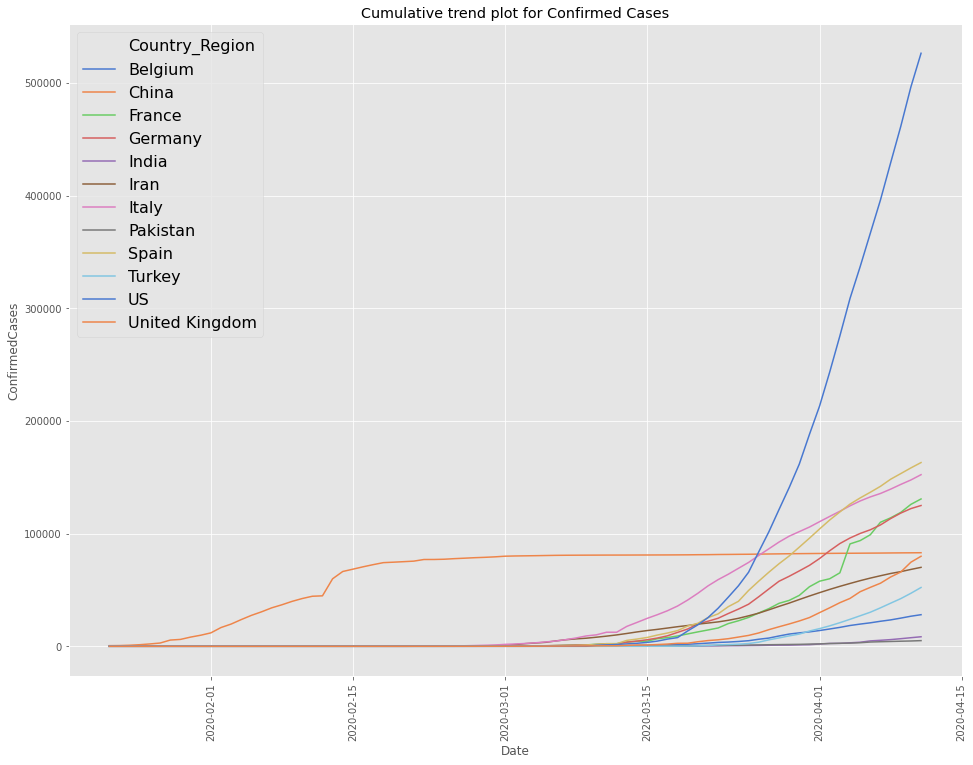

In [15]:
times_series_cntr = train_df.groupby(['Date','Country_Region'])['ConfirmedCases'].sum()\
                    .reset_index().set_index('Date')
df_countries_tm = times_series_cntr[times_series_cntr['Country_Region'].isin(list_countries)]


plt.figure(figsize=(16,12))
ax = sns.lineplot(x=df_countries_tm.index, 
                  y="ConfirmedCases", 
                  hue="Country_Region", 
                  data=df_countries_tm,palette='muted').set_title('Cumulative line')

plt.legend(loc=2, prop={'size': 16})
plt.title('Cumulative trend plot for Confirmed Cases')
plt.xticks(rotation=90);

In the above plot, we can see that China has stabilized its new case reporting while all other countries are showing increase in trend. There is huge variance in dates from when there has been sudden increase in cases.
UK has shown sudden increase in number of confirmed cases since 15 March 2020.

In [16]:
Confirm_pivot=pd.pivot_table(train_df,index='Date',columns='Country_Region',
                             values='ConfirmedCases',aggfunc=np.sum)
Confirm_pivot

Country_Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),...,Sao Tome and Principe,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,548.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,643.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,920.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1406.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2075.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-07,423.0,383.0,1468.0,545.0,17.0,19.0,1628.0,853.0,5895.0,12639.0,717.0,33.0,811.0,164.0,63.0,861.0,22194.0,7.0,26.0,5.0,194.0,764.0,6.0,14034.0,135.0,577.0,384.0,22.0,3.0,7.0,115.0,658.0,17859.0,8.0,10.0,5116.0,82718.0,1780.0,45.0,180.0,...,4.0,2795.0,237.0,2447.0,11.0,6.0,1481.0,581.0,1059.0,8.0,1749.0,2.0,141942.0,185.0,14.0,10.0,7693.0,22253.0,19.0,376.0,24.0,2258.0,1.0,65.0,107.0,623.0,34109.0,396063.0,52.0,1462.0,2359.0,55949.0,424.0,520.0,165.0,249.0,261.0,4.0,39.0,11.0
2020-04-08,444.0,400.0,1572.0,564.0,19.0,19.0,1715.0,881.0,6010.0,12942.0,822.0,40.0,823.0,218.0,63.0,1066.0,23403.0,8.0,26.0,5.0,210.0,804.0,6.0,16170.0,135.0,593.0,414.0,22.0,3.0,7.0,117.0,730.0,19128.0,8.0,10.0,5546.0,82809.0,2054.0,45.0,180.0,...,4.0,2932.0,244.0,2666.0,11.0,7.0,1623.0,682.0,1091.0,12.0,1845.0,2.0,148220.0,189.0,14.0,10.0,8419.0,23280.0,19.0,379.0,25.0,2369.0,1.0,70.0,107.0,628.0,38226.0,428889.0,53.0,1668.0,2659.0,61474.0,424.0,545.0,167.0,251.0,263.0,4.0,39.0,11.0
2020-04-09,484.0,409.0,1666.0,583.0,19.0,19.0,1795.0,921.0,6108.0,13244.0,926.0,41.0,887.0,3

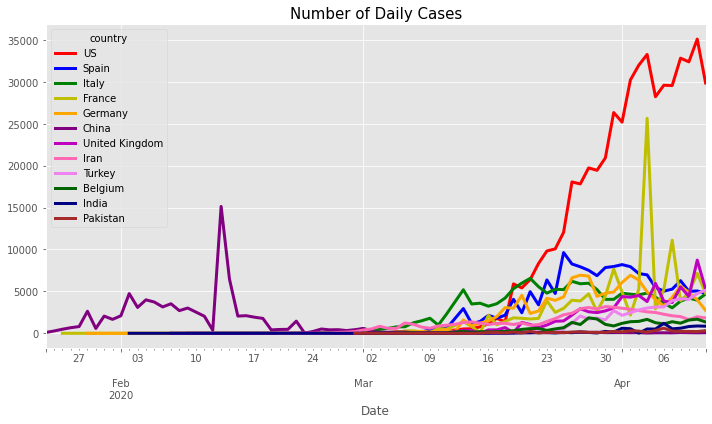

In [17]:
plt.figure(figsize=(10,6))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Confirm=Confirm_pivot[Confirm_pivot[country]>0][country].diff().fillna(0)
    Confirm=Confirm[Confirm>0]
    Confirm.plot(color=colors[i],label=country,markersize=8,lw=3)   
    plt.title('Number of Daily Cases',fontsize=15)
    plt.legend(title='country')
plt.tight_layout()

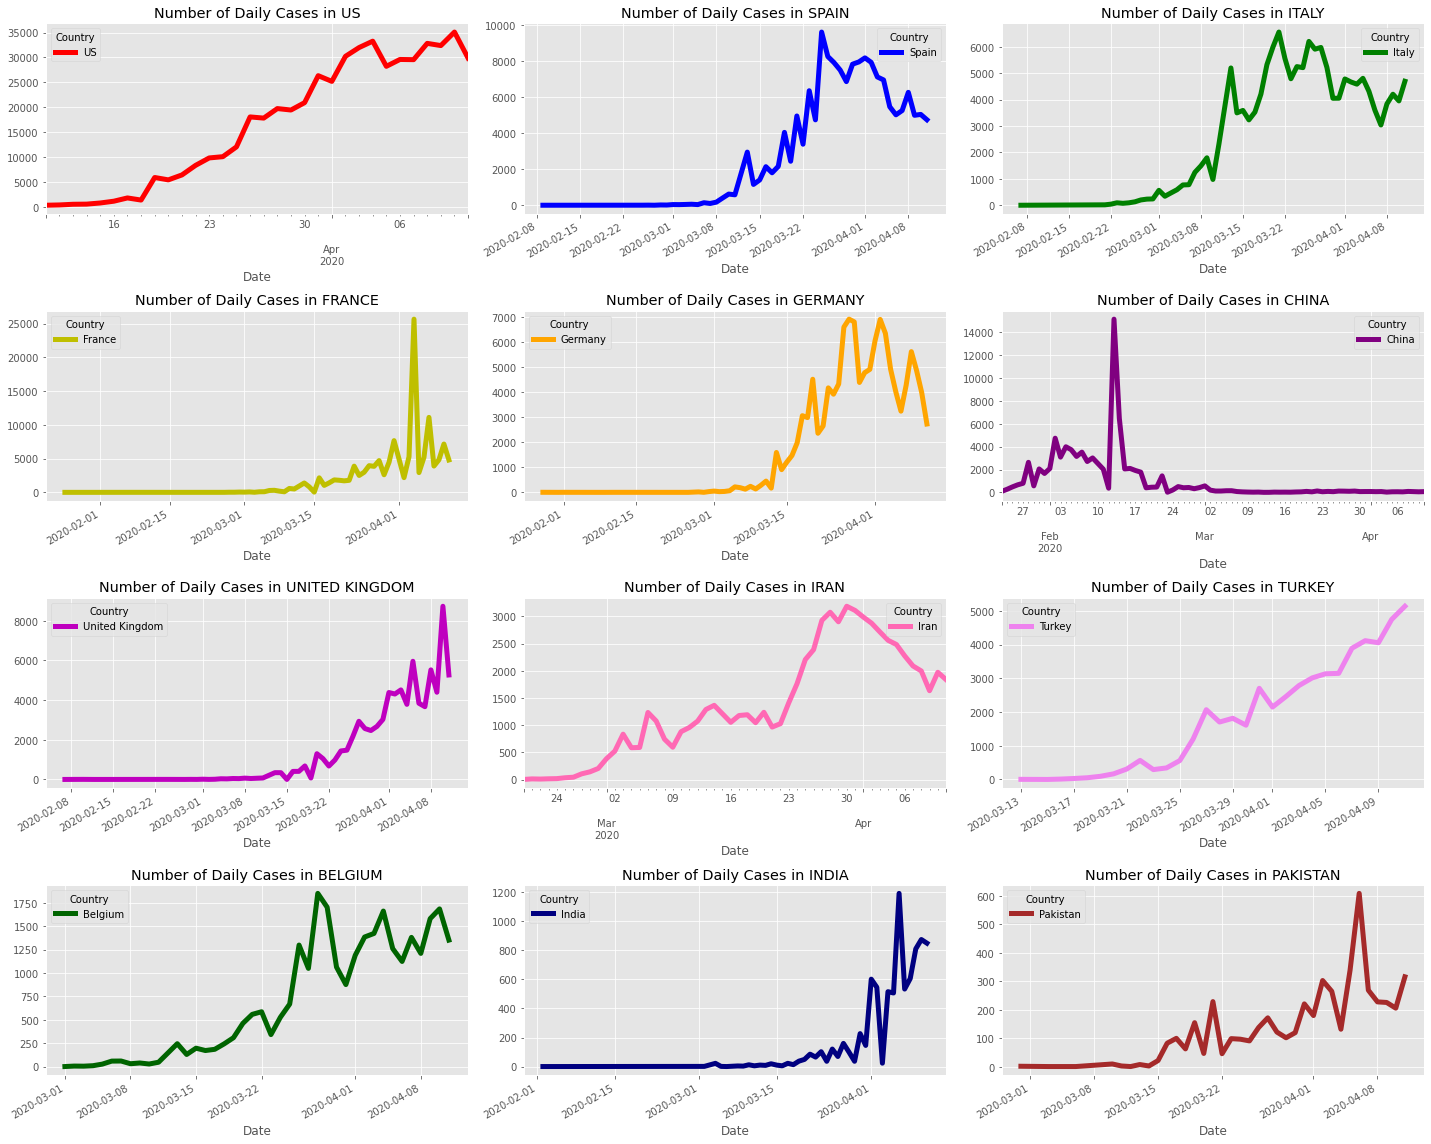

In [18]:
plt.figure(figsize=(20,16))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Confirm=Confirm_pivot[Confirm_pivot[country]>0][country].diff().fillna(0)
    Confirm=Confirm[Confirm>0]
    
    plt.subplot(4,3,i+1)
    Confirm.plot(color=colors[i],label=country,markersize=12,lw=5)    
    plt.xticks()
    plt.legend(title='Country')
    plt.title('Number of Daily Cases in {}'.format(country.upper()))
plt.tight_layout()

In [19]:
coun = []
maxi= []
id_m= []

for country in list_countries:
    id_max=Confirm_pivot[country].diff().fillna(0).idxmax()
    maxim=Confirm_pivot[country].diff().fillna(0).max()
    print('Maximum New Cases registered for {0} was {1} on {2}'.format(country,maxim,id_max))
    coun.append(country)
    maxi.append(maxim)
    id_m.append(id_max)

df_max_case = pd.DataFrame(list(zip(coun, maxi, id_m)), columns =['country', 'max_case', 'date']) 
df_max_case

df_max_case['date']=df_max_case['date'].astype(str)

Maximum New Cases registered for US was 35098.0 on 2020-04-10 00:00:00
Maximum New Cases registered for Spain was 9630.0 on 2020-03-25 00:00:00
Maximum New Cases registered for Italy was 6557.0 on 2020-03-21 00:00:00
Maximum New Cases registered for France was 25646.0 on 2020-04-04 00:00:00
Maximum New Cases registered for Germany was 6933.0 on 2020-03-27 00:00:00
Maximum New Cases registered for China was 15136.0 on 2020-02-13 00:00:00
Maximum New Cases registered for United Kingdom was 8733.0 on 2020-04-10 00:00:00
Maximum New Cases registered for Iran was 3186.0 on 2020-03-30 00:00:00
Maximum New Cases registered for Turkey was 5138.0 on 2020-04-11 00:00:00
Maximum New Cases registered for Belgium was 1850.0 on 2020-03-28 00:00:00
Maximum New Cases registered for India was 1190.0 on 2020-04-06 00:00:00
Maximum New Cases registered for Pakistan was 609.0 on 2020-04-06 00:00:00


In [20]:
fig = px.bar(df_max_case, x=df_max_case.country, y='max_case', text = 'date',
             labels={'x':'country'}, color="country", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Date on which a top 12 countries had Maximum cases')
fig.show()

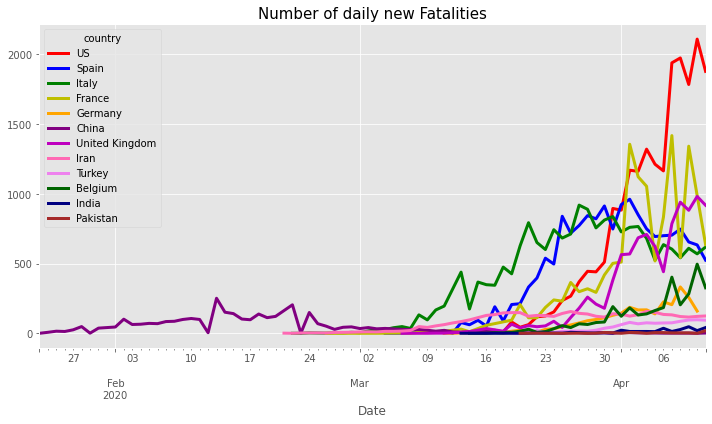

In [21]:
Fatal_pivot=pd.pivot_table(train_df,index='Date',
                           columns='Country_Region',
                           values='Fatalities',
                           aggfunc=np.sum)

plt.figure(figsize=(10,6))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Fatal_diff=Fatal_pivot[Fatal_pivot[country]>0][country].diff().fillna(0)
    Fatal_diff=Fatal_diff[Fatal_diff>0]
    Fatal_diff.plot(color=colors[i],label=country,markersize=8,lw=3)   
    plt.title('Number of daily new Fatalities',fontsize=15)
    plt.legend(title='country')
plt.tight_layout()

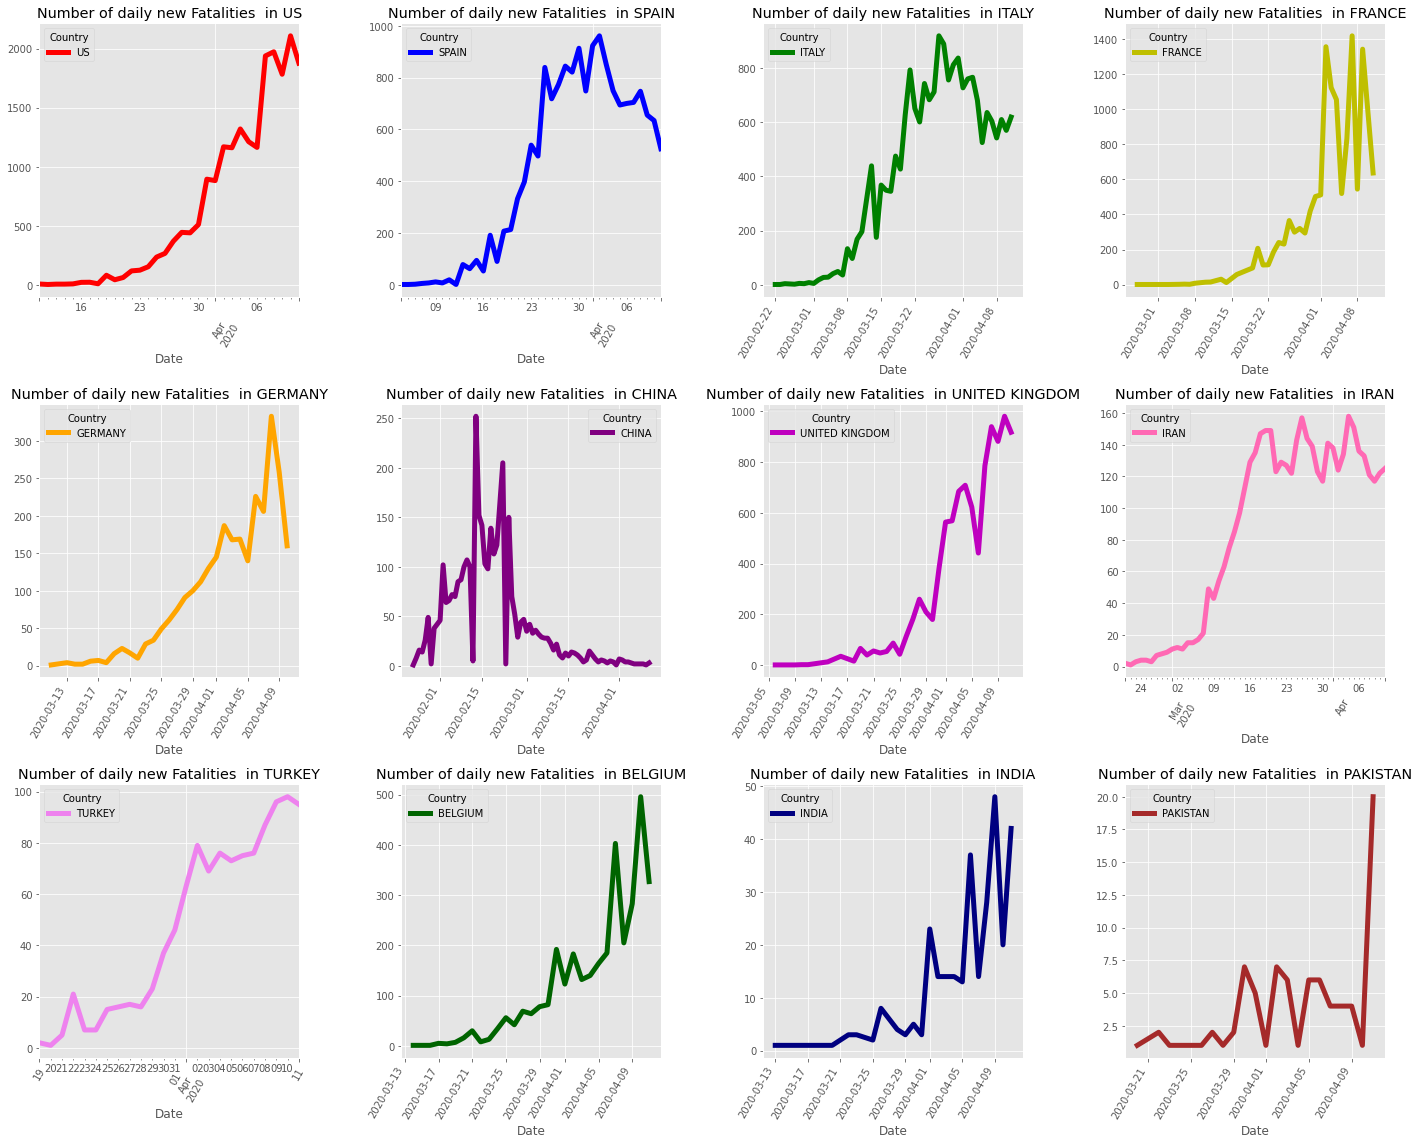

In [22]:
plt.figure(figsize=(20,16))
for i,country in enumerate(list_countries):
    Fatal_diff=Fatal_pivot[(Fatal_pivot[country]>0)][country].diff().fillna(0)
    Fatal_diff=Fatal_diff[Fatal_diff>0]
    plt.subplot(3,4,i+1)
    Fatal_diff.plot(color=colors[i],label=country.upper(),lw=5)
    plt.xticks(rotation=60)
    plt.title('Number of daily new Fatalities  in {}'.format(country.upper()))
    plt.legend(title='Country')
plt.tight_layout()

In [23]:
coun = []
maxi= []
id_m= []

for country in list_countries:
    id_max=Fatal_pivot[country].diff().fillna(0).idxmax()
    maxim=Fatal_pivot[country].diff().fillna(0).max()
    print('Maximum Fatalities for {0} was {1} on {2}'.format(country,maxim,id_max))
    coun.append(country)
    maxi.append(maxim)
    id_m.append(id_max)

df_max_fat = pd.DataFrame(list(zip(coun, maxi, id_m)), columns =['country', 'max_fat', 'date']) 
df_max_fat

df_max_fat['date']=df_max_fat['date'].astype(str)

Maximum Fatalities for US was 2108.0 on 2020-04-10 00:00:00
Maximum Fatalities for Spain was 961.0 on 2020-04-02 00:00:00
Maximum Fatalities for Italy was 919.0 on 2020-03-27 00:00:00
Maximum Fatalities for France was 1417.0 on 2020-04-07 00:00:00
Maximum Fatalities for Germany was 333.0 on 2020-04-08 00:00:00
Maximum Fatalities for China was 252.0 on 2020-02-13 00:00:00
Maximum Fatalities for United Kingdom was 981.0 on 2020-04-10 00:00:00
Maximum Fatalities for Iran was 158.0 on 2020-04-04 00:00:00
Maximum Fatalities for Turkey was 98.0 on 2020-04-10 00:00:00
Maximum Fatalities for Belgium was 496.0 on 2020-04-10 00:00:00
Maximum Fatalities for India was 48.0 on 2020-04-09 00:00:00
Maximum Fatalities for Pakistan was 20.0 on 2020-04-11 00:00:00


In [24]:
fig = px.bar(df_max_fat, x=df_max_fat.country, y='max_fat', text = 'date',
             labels={'x':'country'}, color="country", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Date on which a top 12 countries had Maximum Fatalities')
fig.show()

Text(0.5, 0.98, 'Variation in number of confirmed cases on daily basis')

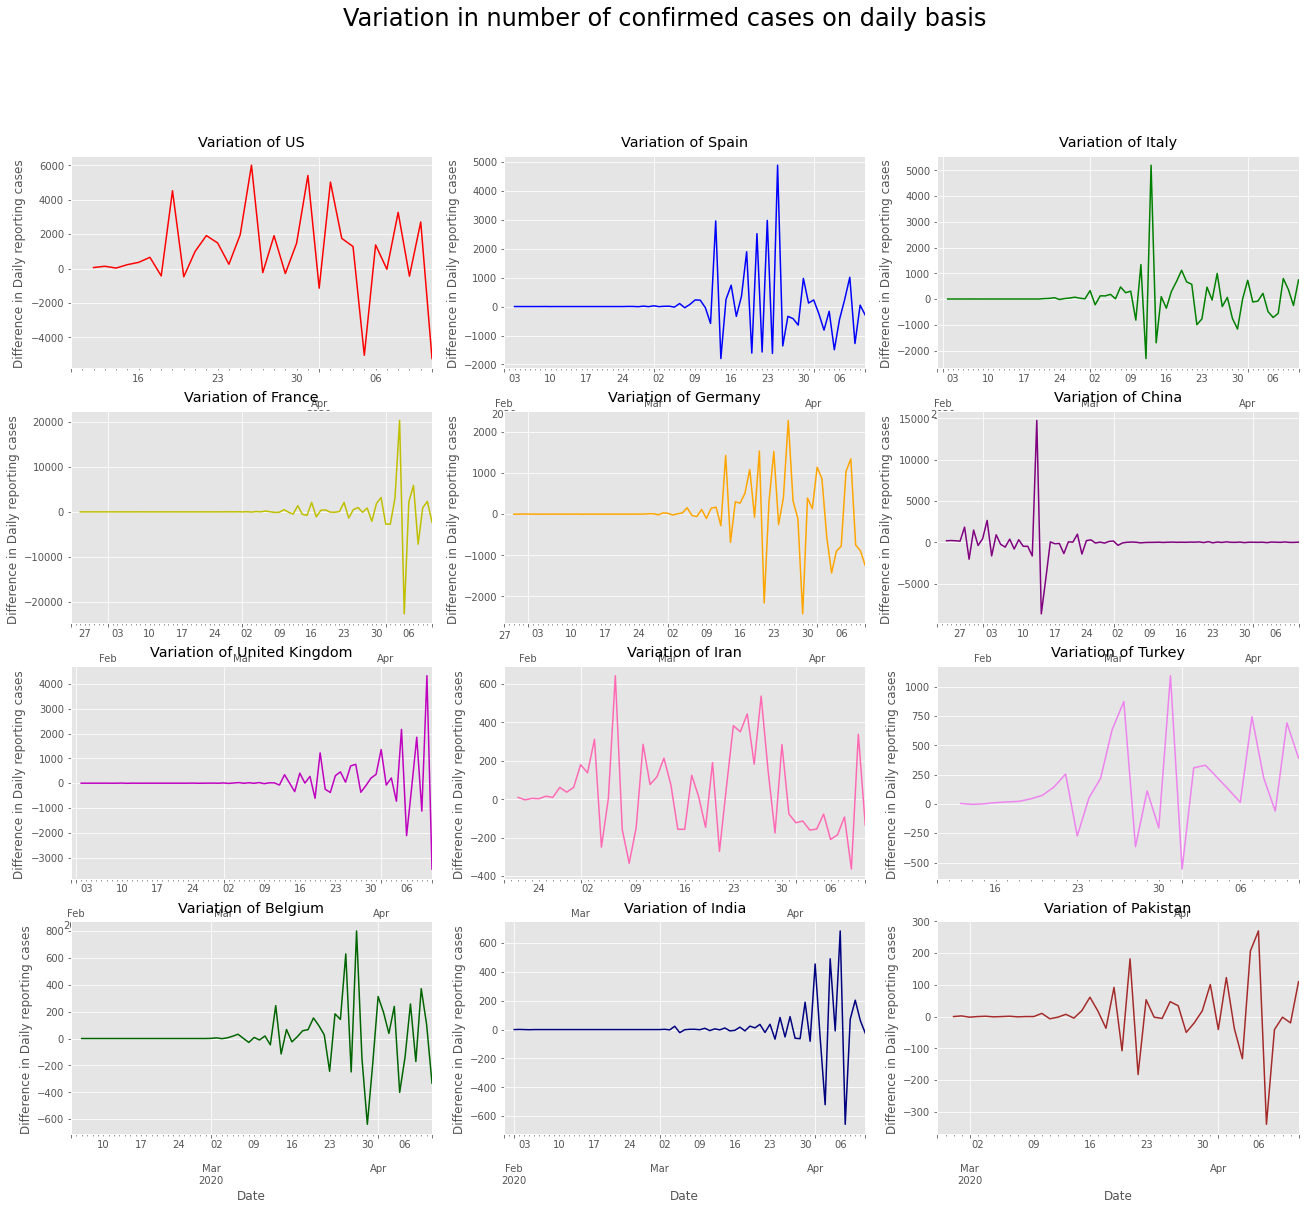

In [25]:
# Understanding New cases confirmation variations on daily basis
plt.figure(figsize=(22,18))
for i,country in enumerate(list_countries):
    plt.subplot(4,3,i+1)
    train_df[(train_df['Country_Region']==country)&(train_df['ConfirmedCases']!=0)].groupby('Date')['ConfirmedCases'].sum().diff().diff().plot(color=colors[i])
    plt.ylabel('Difference in Daily reporting cases ')
    plt.title('Variation of {}'.format(country),va='bottom')
plt.suptitle('Variation in number of confirmed cases on daily basis',fontsize=24,va='baseline')

### Part 3: Exploratory Data Analysis

Q3.1. Confirmed Cases trend (pattern) from first day of incidence (confirmed cases)

Q3.2. Fatalities trend from first day of incidence

Q3.3. Comparision of Confirmed Cases and Fatalities worldwide trend on normal and log scale

Q3.4. Corelation between ConfirmedCases and Fatalities worldwide

Q3.5. Confirmed Cases worldwide trend (without China)

Q3.5. Fatalities Cases worldwide trend (without China)



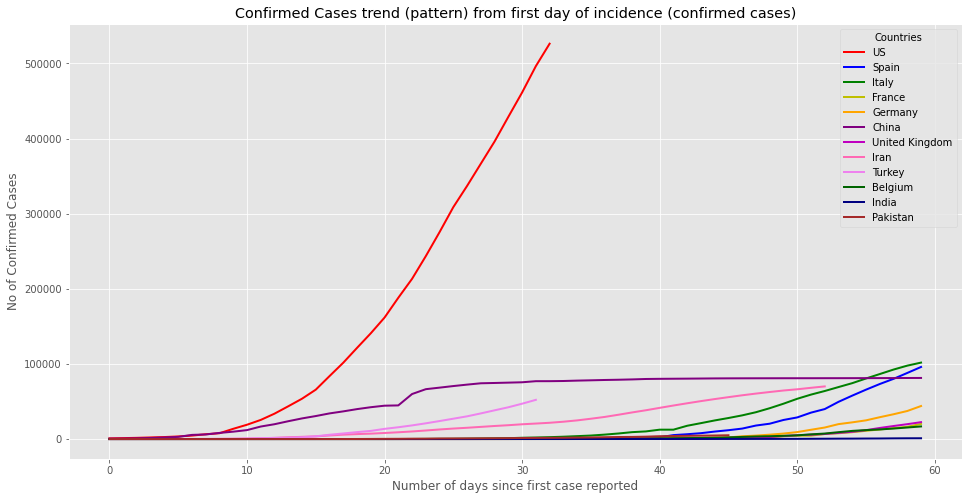

In [26]:
plt.figure(figsize=(16,8))
plt.title('Confirmed Cases trend (pattern) from first day of incidence (confirmed cases)')
for i,country in enumerate(list_countries):
    confirm_group=train_df[(train_df['Country_Region']==country)&train_df['ConfirmedCases']!=0].groupby('Date').agg({'ConfirmedCases':['sum']})
    confirm_value=[j for j in confirm_group.ConfirmedCases['sum'].values]
    plot_value=confirm_value[0:60]
    plt.plot(plot_value,color=colors[i],label=country,lw=2)
    plt.legend(title='Countries')
    plt.xlabel("Number of days since first case reported")
    plt.ylabel("No of Confirmed Cases")

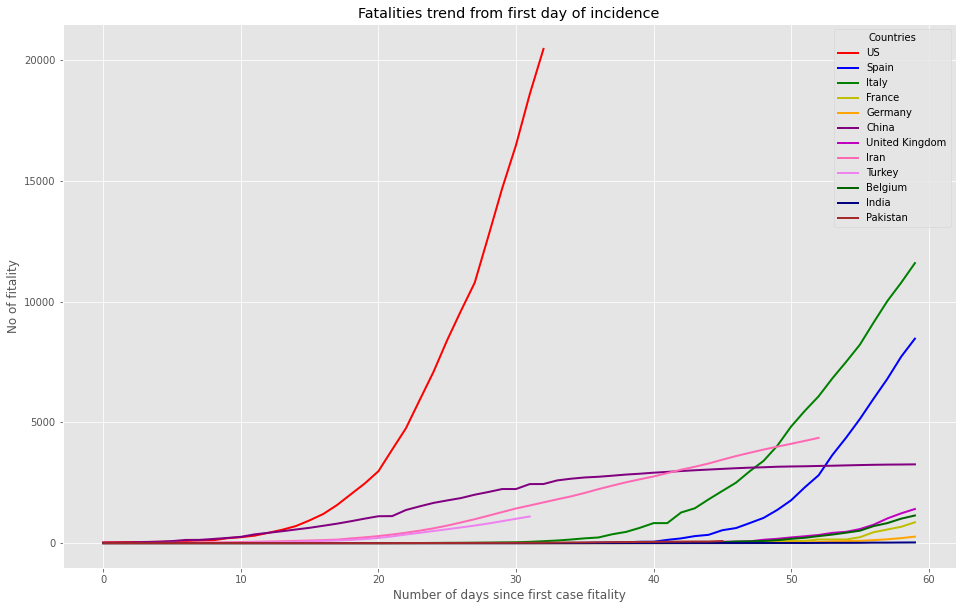

In [27]:
plt.figure(figsize=(16,10))
plt.title('Fatalities trend from first day of incidence')
for i,country in enumerate(list_countries):
    fatal_group=train_df[(train_df['Country_Region']==country)&train_df['ConfirmedCases']!=0].groupby('Date').agg({'Fatalities':['sum']})
    fatal_value=[j for j in fatal_group.Fatalities['sum'].values]
    plot_value=fatal_value[0:60]
    plt.plot(plot_value,color=colors[i],label=country,lw=2)
    plt.legend(title='Countries')
    plt.xlabel("Number of days since first case fitality")
    plt.ylabel("No of fitality")

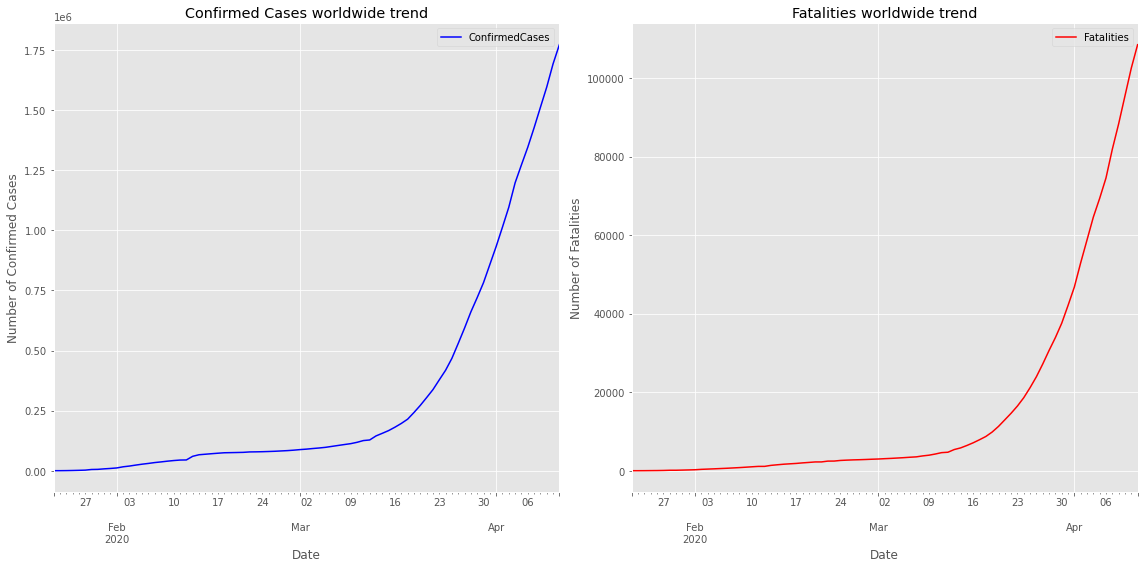

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
train_df.groupby('Date')['ConfirmedCases'].sum().plot(color='blue')
plt.ylabel('Number of Confirmed Cases')
plt.legend()
plt.title('Confirmed Cases worldwide trend')

plt.subplot(1,2,2)
train_df.groupby('Date')['Fatalities'].sum().plot(color='r')
plt.ylabel('Number of Fatalities')
plt.title("Fatalities worldwide trend")
plt.legend()
plt.tight_layout()

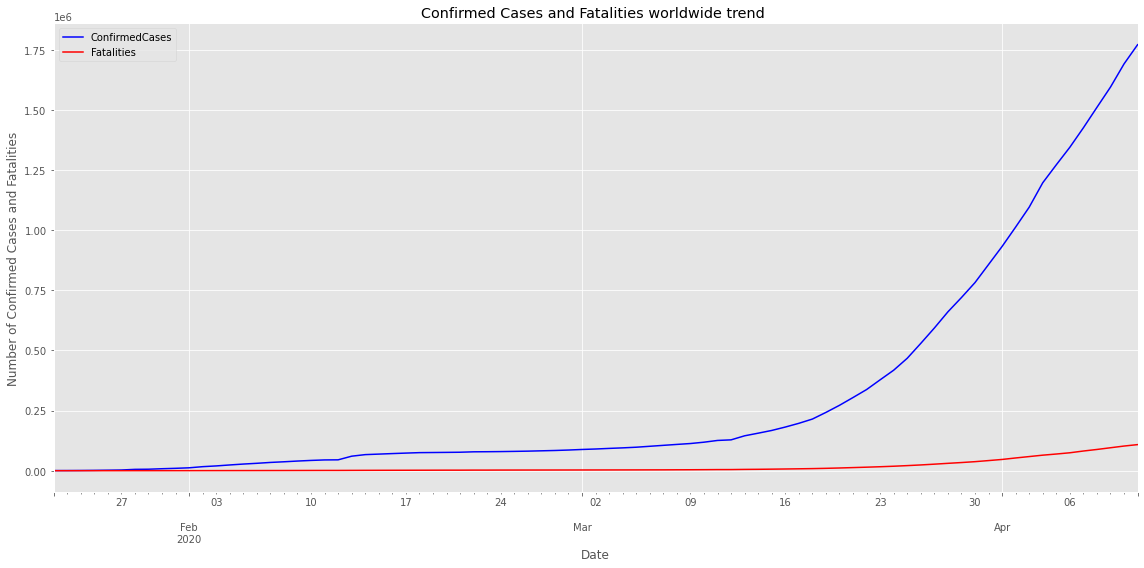

In [29]:
plt.figure(figsize=(16,8))
train_df.groupby('Date')['ConfirmedCases'].sum().plot(color='blue')
train_df.groupby('Date')['Fatalities'].sum().plot(color='r')
plt.ylabel('Number of Confirmed Cases and Fatalities')
plt.title('Confirmed Cases and Fatalities worldwide trend ')
plt.legend()
plt.tight_layout()

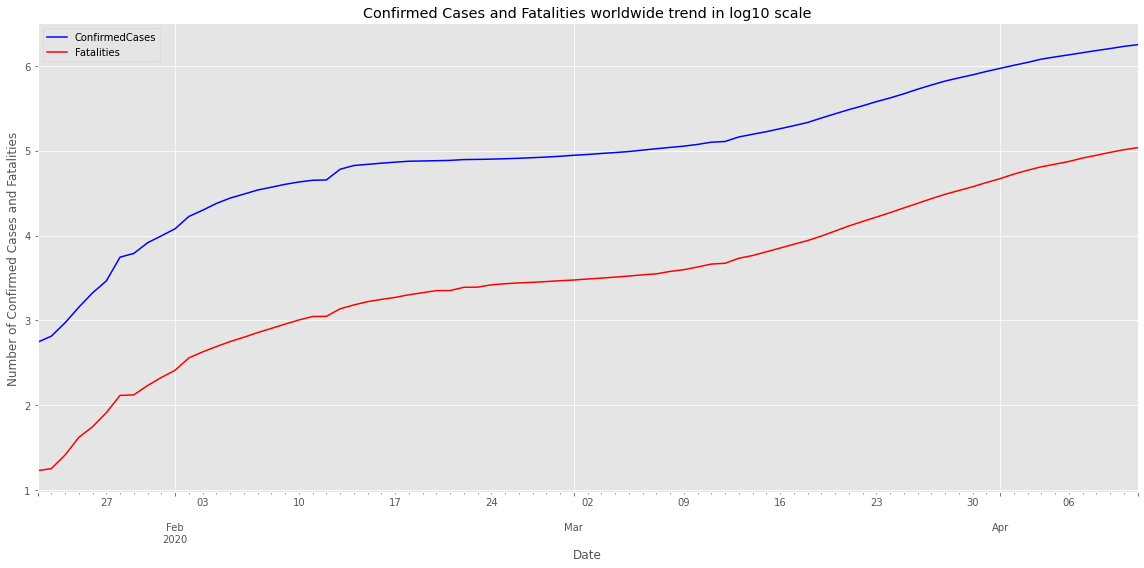

In [30]:
plt.figure(figsize=(16,8))
np.log10(train_df.groupby('Date')['ConfirmedCases'].sum()).plot(color='blue')
np.log10(train_df.groupby('Date')['Fatalities'].sum()).plot(color='r')
plt.ylabel('Number of Confirmed Cases and Fatalities')
plt.title('Confirmed Cases and Fatalities worldwide trend in log10 scale')
plt.legend()
plt.tight_layout()

In [47]:
cc=train_df.groupby('Date')['ConfirmedCases'].sum()
ft=train_df.groupby('Date')['Fatalities'].sum()

fig = go.Figure(data=go.Scatter(x=cc, y=ft, mode='lines+markers'))
# Edit the layout
fig.update_layout(title='Corelation between ConfirmedCases and Fatalities worldwide',
                   xaxis_title='Confirmed Cases ',
                   yaxis_title='Fatalities')
fig.show()

correlation_matrix = np.corrcoef(cc, ft)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.9914565564745231


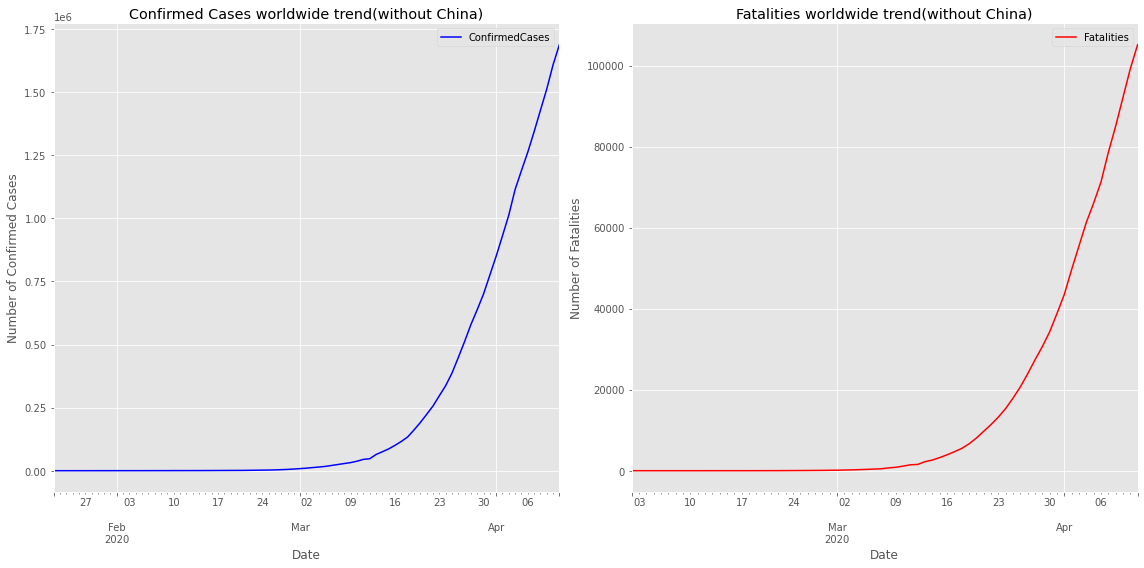

In [32]:
# Confirmed Cases and Fatalities without China's data
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
train_df[(train_df['Country_Region']!='China')&(train_df['ConfirmedCases']!=0)].groupby('Date')['ConfirmedCases'].sum().plot(color='blue')
plt.ylabel('Number of Confirmed Cases')
plt.legend()
plt.title('Confirmed Cases worldwide trend(without China)')

plt.subplot(1,2,2)
train_df[(train_df['Country_Region']!='China')&(train_df['Fatalities']!=0)].groupby('Date')['Fatalities'].sum().plot(color='red')
plt.ylabel('Number of Fatalities')
plt.title("Fatalities worldwide trend(without China)")
plt.legend()
plt.tight_layout()

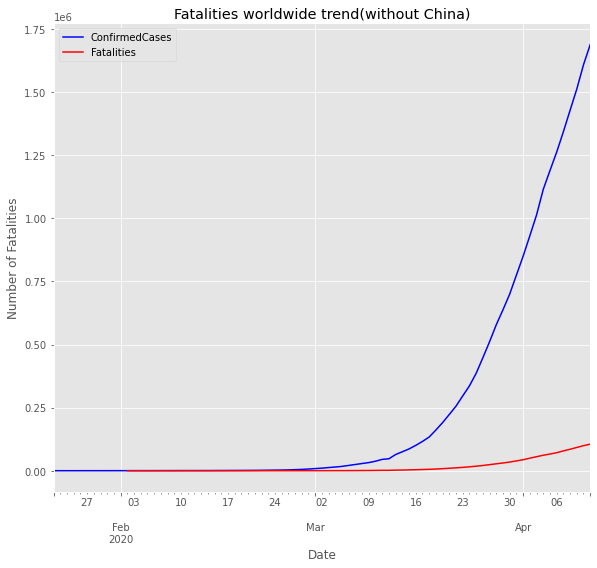

In [33]:
# Confirmed Cases and Fatalities without China's data
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
train_df[(train_df['Country_Region']!='China')&(train_df['ConfirmedCases']!=0)].groupby('Date')['ConfirmedCases'].sum().plot(color='blue')
train_df[(train_df['Country_Region']!='China')&(train_df['Fatalities']!=0)].groupby('Date')['Fatalities'].sum().plot(color='red')
plt.ylabel('Number of Fatalities')
plt.title("Fatalities worldwide trend(without China)")
plt.legend()
plt.tight_layout()

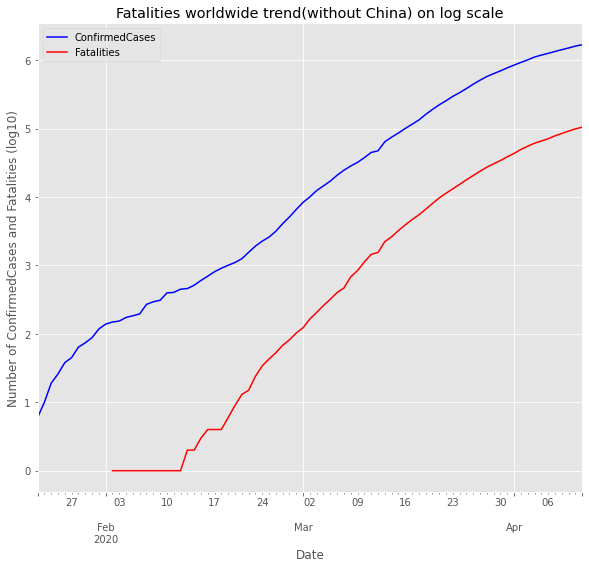

In [34]:
# Confirmed Cases and Fatalities without China's data on Log scale
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
np.log10(train_df[(train_df['Country_Region']!='China')&(train_df['ConfirmedCases']!=0)].groupby('Date')['ConfirmedCases'].sum()).plot(color='blue')
np.log10(train_df[(train_df['Country_Region']!='China')&(train_df['Fatalities']!=0)].groupby('Date')['Fatalities'].sum()).plot(color='red')
plt.ylabel('Number of ConfirmedCases and Fatalities (log10)')
plt.title("Fatalities worldwide trend(without China) on log scale")
plt.legend()
plt.tight_layout()

Conclusion of Exploratory Data Analysis:

1. China

According to the news and media Covid-19 has been started from China and the first case was reported in December 2019. The data published on Kaggle has a start date of data collection from 22nd Jan 2020 onwards and by that time in China the confirmed cases were 533. 

2. Italy

Italy has confirmed first case in the end of Jan 2020 (i.e. a month later to China). Italy surpasses China in confirmed cases around 3-4 week of March 2020 and currently third largest in number of registered cases. 

These answers are based on the data obtained by 5th April 2020

Q1. Which countries has high number of cases?
A1. US followed by Spain and Italy 

Q2. How is confirmed cases increases by day?
A2. 

Q3. What is fatality rate of confirmed cases?
Q4. How is cases increasing by day of 1st reported case?
Q5. Understanding data of India and UK and comparing it with the world?
Q6. What is new rate of increase per case per day?



### Let's do Prediction Now

In [35]:
test_df['Date']=pd.to_datetime(test_df['Date'])
test_df

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06
...,...,...,...,...
13454,13455,NaN,Zimbabwe,2020-05-10
13455,13456,NaN,Zimbabwe,2020-05-11
13456,13457,NaN,Zimbabwe,2020-05-12
13457,13458,NaN,Zimbabwe,2020-05-13


In [0]:
test_df['Province_State']=test_df.drop('Province_State',axis=1)


In [0]:
train_df=train_df.reset_index()

In [0]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()

train_df['Country_Region']=LE.fit_transform(train_df['Country_Region'])
test_df['Country_Region']=LE.transform(test_df['Country_Region'])

train_df.loc[:, 'Date'] = train_df.Date.dt.strftime("%m%d")
train_df["Date"]  = train_df["Date"].astype(int)

test_df.loc[:, 'Date'] = test_df.Date.dt.strftime("%m%d")
test_df["Date"]  = test_df["Date"].astype(int)


In [39]:
#Select feature column names and target variable we are going to use for training
features=['Date','Country_Region']
target = 'ConfirmedCases'

#This is input which our classifier will use as an input.
train_df[features].head(10)

,Date,Country_Region
0,122,0
1,123,0
2,124,0
3,125,0
4,126,0
5,127,0
6,128,0
7,129,0
8,130,0
9,131,0


In [40]:
from sklearn.ensemble import RandomForestClassifier

# We define the model
rfcla = RandomForestClassifier(n_estimators=10, max_samples=0.8,
                        random_state=1)
# We train model
rfcla.fit(train_df[features],train_df[target])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [41]:
#Make predictions using the features from the test data set
predictions = rfcla.predict(test_df[features])

predictions

array([273., 281., 299., ...,  14.,  14.,  14.])

In [0]:
target2='Fatalities'

In [43]:
# We define the model
rfcla2 = RandomForestClassifier(n_estimators=10, max_samples=0.8,
                        random_state=1)
# We train model
rfcla2.fit(train_df[features],train_df[target2])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [44]:
#Make predictions using the features from the test data set
predictions2 = rfcla2.predict(test_df[features])

print(predictions2[0:500])

[  6.   6.   7.   7.  11.  14.  14.  15.  15.  23.  23.  23.  23.  23.
  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.
  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.
  23.  16.   6.  20.  20.  21.  22.  22.  23.  23.  23.  23.  23.  23.
  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.
  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.
  23.  23.  86. 105. 130. 152. 173. 193. 205. 235. 256. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275. 275.
 275. 275. 275.  15.  16.  17.  18.  21.  22.  23.  25.  26.  26.  26.
  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.
  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.
  26.  26.  26.  26.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
   2. 

In [45]:
#Create a  DataFrame
submission = pd.DataFrame({'ForecastId':test_df['ForecastId'],'ConfirmedCases':predictions,'Fatalities':predictions2})
                        

#Visualize the first 10 rows
submission.head(10)

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0
5,6,423.0,14.0
6,7,444.0,14.0
7,8,484.0,15.0
8,9,521.0,15.0
9,10,433.0,23.0


In [46]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'submission.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: submission.csv
